# 5 Seq2Seq AMC+Demodulation on different length sequences

## Import libraries

In [3]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import awgn, make_rrc, modulate, demodulate, pulse_shape

## Define baseline

In [4]:
def calc_baseline(snr, num_iter=512, M=2, sps = 4, span = 10):
    
    num_weights = sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    ints = np.random.randint(low=0, high=M, size=(num_iter))
    samples = modulate(ints, M=M)
    
    samples = pulse_shape(samples, hrrc, sps=sps)
    samples = awgn(samples, snr, measured=True)

    syms_filtered = np.convolve(samples, hrrc, mode='same')
    extract_symbols = syms_filtered[np.arange(0,len(samples),sps)]
    extract_symbols /= np.sqrt(np.mean(np.abs(extract_symbols)**2)) # normalize to unit power
    
    num_correct = sum(demodulate(extract_symbols, M=M) == ints)
    
    return num_correct/num_iter

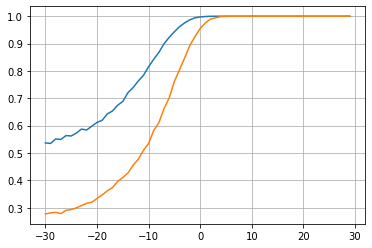

In [5]:
snr_range = np.arange(-30,30)

bpsk_baseline, qpsk_baseline, psk_baseline = [], [], []
for snr in snr_range:
    bpsk_baseline.append(calc_baseline(snr=snr, M=2, num_iter=1024*16))
    qpsk_baseline.append(calc_baseline(snr=snr, M=4, num_iter=1024*16))
#     psk_baseline.append(calc_baseline(snr=snr, M=8, num_iter=2048))

bpsk_baseline = np.array(bpsk_baseline)
qpsk_baseline = np.array(qpsk_baseline)
# psk_baseline = np.array(psk_baseline)
    
plt.plot(snr_range, bpsk_baseline)
plt.plot(snr_range, qpsk_baseline)
# plt.plot(snr_range, psk_baseline)
# plt.plot(snr_range, (bpsk_baseline+qpsk_baseline+psk_baseline)/3, '--')
plt.grid()

## Generate training data

We will need pairs of sequences of pulse shaped symbols and labels. 

E.g. when training for 5 pulse shaped symbols at sps=4, we will have a x_train inputs be of shape batch x 20 x 2, where the last dimension represents real and imaginary channels, and the corresponding y_train will be a sequence of batch x 5, for the 5 classes reprented in 5 pulse shaped symbols taking up 20 samples.

In [6]:
def gen_data(num_examples, seq_length, mod_order=4, sps=4, span=10, snr=50, normalize=True):
    '''
    This function produces a num_examples number of pulse shaped M-QAM waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate random bits
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples * seq_length))
    
    # Modulate according to mod order
    samples = modulate(ints, M=mod_order)
    
    # Pulse shape / upsample the symbols
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    samples_noisy = awgn(samples_pulse_shaped, snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = samples_noisy.reshape(num_examples,-1)
    labels = ints.reshape(num_examples,-1)
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True, num_classes=None):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        if num_classes:
            y = F.one_hot(y, num_classes=num_classes)
        else:
            y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

Define the encoder and decoder for our autoencoder structure. There's no init function for the decoder as it will only ever be using the one that the encoder provides.

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', dropout=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout)

    def forward(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        
        return output, hidden
    
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', dropout=0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
        rnn_output = self.dropout(rnn_output)
        y = self.out(rnn_output)
        
        return y, hidden

## Training

Define the training and validation functions for one epoch.

In [8]:
def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, tf_ratio=0, gpu=True, num_classes=6):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # format to (seq x batch x feats) format
    x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    loss = 0

    encoder_hidden = encoder.initHidden(batch_size=x_train.shape[1], device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_train, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,x_train.shape[1],num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_train.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_train[i].squeeze().float()) # MSE
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy
#         loss += criterion(F.log_softmax(y.squeeze(),dim=1), y_train[i].argmax(axis=1)) #NLLLoss

        # the higher the ratio the higher the chance of forcing
        teacher_forcing = np.random.random() < tf_ratio

        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True, num_classes=6):

    x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    loss = 0

    encoder_hidden = encoder.initHidden(batch_size=x_val.shape[1], device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_val, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,x_val.shape[1],num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float()) #mse
        loss += criterion(y.squeeze(), y_val[i].argmax(axis=1)) # cross-entropy
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

def gen_dataset(data_config, train_config):
    
    # if multiple SNR
    if type(data_config['snr']) == np.ndarray:
        datas, labels = [], []
        for sn in data_config['snr']:
            if data_config['num_examples_bpsk'] > 0:
                x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'],
                                data_config['seq_length'],
                                sps=data_config['sps'],
                                mod_order=2,
                                snr=sn)
                datas.append(x_bpsk)
                labels.append(y_bpsk)
            
            if data_config['num_examples_qpsk'] > 0:
                x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'],
                                data_config['seq_length'],
                                sps=data_config['sps'],
                                mod_order=4,
                                snr=sn)
                
                y_qpsk += 2
                
                datas.append(x_qpsk)
                labels.append(y_qpsk)

        x = np.concatenate((datas))
        y = np.concatenate((labels))
    
    # if single SNR
    else:
        x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=2, sps=data_config['sps'], 
                                  snr=data_config['snr'])

        x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=4, sps=data_config['sps'], 
                                  snr=data_config['snr'])
        y_qpsk += 2
        x = np.concatenate((x_bpsk, x_qpsk))
        y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True, num_classes=6)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    
    return train_dataloader

def inference(x_test, encoder, decoder, num_classes=6, seq_length=5, batch_size=32, device='cpu'):

    encoder_hidden = encoder.initHidden(batch_size=batch_size, device=device)
    _, encoder_hidden = encoder(x_test, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,num_classes), device=device)
    decoder_input = torch.zeros((1,batch_size,num_classes), device=device)
    
    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y
        
    return decoder_outputs

def eval_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6, batch_size=32, gpu=True):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x, y = to_tensors(x, y, batch_first=True, gpu=gpu)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes, seq_length=seq_length, device='cuda' if gpu else 'cpu')

            corrects += torch.sum(y_hat.argmax(axis=2) == y.squeeze())

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

## Generate training and validation datasets

In [9]:
def gen_validation_dataloader(snrs, seq_length, examples_per_snr=32):
    ## bpsk
    datas, labels = [], []
    for snr in snrs:
        x_bpsk, y_bpsk = gen_data(examples_per_snr, seq_length, mod_order=2, sps=4, snr=snr)
        datas.append(x_bpsk)
        labels.append(y_bpsk)
        
    x_bpsk = np.concatenate((datas))
    y_bpsk = np.concatenate((labels))

    x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=True, onehot=True, num_classes=6)
    val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=32, shuffle=True)

    ## qpsk
    datas, labels = [], []
    for snr in snrs:
        x_qpsk, y_qpsk = gen_data(examples_per_snr, seq_length, mod_order=4, sps=4, snr=snr)
        datas.append(x_qpsk)
        labels.append(y_qpsk)
        
    x_qpsk = np.concatenate((datas))
    y_qpsk = np.concatenate((labels))
    y_qpsk += 2

    x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=True, onehot=True, num_classes=6)
    val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=32, shuffle=True)

    return val_dataloader_bpsk, val_dataloader_qpsk

In [10]:
def train_network(data_config, train_config, model_config=(16,3), gpu=True, dropout=0, tf_rate=0, numpy_seed=0, torch_seed=0, savepath='models/bpsk_qpsk_seq2seq.pt'):        
        np.random.seed(numpy_seed)
        train_dataloader = gen_dataset(data_config, train_config)
        val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(data_config['snr'], data_config['seq_length'])

        criterion = nn.CrossEntropyLoss()

        torch.manual_seed(torch_seed)
        
        # Create the encoder and decoder models
        encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], dropout=dropout, device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], dropout=dropout, device = 'cuda' if gpu else 'cpu')

        encoder.cuda()
        decoder.cuda()

        # Initialize the optimizers
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=train_config['learning_rate'], weight_decay=train_config['weight_decay'])
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=train_config['learning_rate'], weight_decay=train_config['weight_decay'])

        # Define empty lists where loss progress will be stored
        losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

        best_loss = np.inf

        # Training loop
        for epoch in range(train_config['num_epochs']):
            train_loss = 0
            for x_train,y_train in train_dataloader:

                train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, tf_ratio=tf_rate, gpu=gpu)

            losses.append(train_loss/len(train_dataloader))

            with torch.no_grad():
                val_loss = 0
                for x_val,y_val in val_dataloader_bpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                val_loss = 0
                for x_val,y_val in val_dataloader_qpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                val_losses.append(val_loss)

                if val_loss < best_loss:
                    encoder_weights = encoder.state_dict()
                    decoder_weights = decoder.state_dict()
                    best_loss = val_losses[-1]
                    print(f"{epoch}: Best loss {best_loss}, saving...")

        encoder.load_state_dict(encoder_weights)
        decoder.load_state_dict(decoder_weights)
        
        train_results = {'encoder': encoder_weights,
                        'decoder': decoder_weights,
                        'losses': losses,
                        'val_losses': val_losses,
                        'val_losses_bpsk': val_losses_bpsk,
                        'val_losses_qpsk': val_losses_qpsk}
        
        print(f"Saving training results to {savepath}")
        torch.save(train_results, savepath)

In [11]:
model_config = {'hidden_size': 16,
                'num_layers': 3,
                'input_size': 2,
                'output_size': 6}

# 'snr': np.array([-10, -5, 0, 5, 10, 15])
data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 2048,
               'num_examples_qpsk': 2048,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

train_config = {'num_epochs': 250,
                'batch_size': 64,
                'learning_rate': 3e-4,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'tf_ratio': 0}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

## Just weight decay

In [13]:
seq_lengths = [10,15,20]
model_configs = [(16,3), (128,3)]
train_config['num_epochs'] = 250
for seq_length in seq_lengths:
    for model_config in model_configs:
        data_config['seq_length'] = seq_length

        train_network(data_config, train_config, model_config=(16,3), gpu=True, dropout=0, tf_rate=0, numpy_seed=0, torch_seed=0, 
                      savepath=f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_2048_{train_config['num_epochs']}_epochs.pt")

0: Best loss 1.7323810895284018, saving...
1: Best loss 1.2137800415356952, saving...
2: Best loss 1.18321586449941, saving...
3: Best loss 1.1574120759963988, saving...
4: Best loss 1.151079249382019, saving...
5: Best loss 1.1509033997853597, saving...
6: Best loss 1.1347309350967407, saving...
8: Best loss 1.110803731282552, saving...
9: Best loss 1.1030313769976297, saving...
10: Best loss 1.0963377912839252, saving...
11: Best loss 1.084485948085785, saving...
12: Best loss 1.0686754743258158, saving...
13: Best loss 1.0517144759496053, saving...
15: Best loss 1.035528286298116, saving...
16: Best loss 1.0274872263272603, saving...
17: Best loss 1.0199763695398967, saving...
18: Best loss 1.0167801102002463, saving...
19: Best loss 1.005366305510203, saving...
20: Best loss 0.9922241886456807, saving...
21: Best loss 0.9746516386667887, saving...
22: Best loss 0.9609691977500916, saving...
23: Best loss 0.9544221997261048, saving...
24: Best loss 0.9458236932754517, saving...
25: 

## Add teacher forcing

In [14]:
seq_lengths = [10,15,20]
model_configs = [(16,3), (128,3)]
train_config['num_epochs'] = 250
tf_ratios = [0.25,0.5]
for tf_ratio in tf_ratios:
    for seq_length in seq_lengths:
        for model_config in model_configs:
            data_config['seq_length'] = seq_length

            train_network(data_config, train_config, model_config=(16,3), gpu=True, dropout=0, tf_rate=tf_ratio, numpy_seed=0, torch_seed=0, 
                        savepath=f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_2048_tf_ratio_{tf_ratio}_{train_config['num_epochs']}_epochs.pt")

0: Best loss 1.7268521467844646, saving...
1: Best loss 1.252894691626231, saving...
2: Best loss 1.1950663288434347, saving...
3: Best loss 1.1888446966807047, saving...
4: Best loss 1.1660877307256063, saving...
5: Best loss 1.1419851541519166, saving...
6: Best loss 1.1371471444765726, saving...
7: Best loss 1.131692659854889, saving...
8: Best loss 1.1121546188990274, saving...
9: Best loss 1.1084344903628032, saving...
12: Best loss 1.0831317901611328, saving...
13: Best loss 1.0748254855473833, saving...
14: Best loss 1.0606040636698404, saving...
16: Best loss 1.0397382656733194, saving...
18: Best loss 1.036305022239685, saving...
19: Best loss 1.0294407963752745, saving...
20: Best loss 1.0269316236178079, saving...
21: Best loss 1.016840887069702, saving...
22: Best loss 1.008637837568919, saving...
23: Best loss 0.9971877694129943, saving...
26: Best loss 0.9900003393491109, saving...
27: Best loss 0.9794383247693381, saving...
29: Best loss 0.9611142436663309, saving...
30:

## Add dropout

In [15]:
seq_lengths = [10,15,20]
model_configs = [(16,3), (128,3)]
train_config['num_epochs'] = 250
dropouts = [0.25,0.5]
for dropout in dropouts:
    for seq_length in seq_lengths:
        for model_config in model_configs:
            data_config['seq_length'] = seq_length

            train_network(data_config, train_config, model_config=(16,3), gpu=True, dropout=dropout, tf_rate=0, numpy_seed=0, torch_seed=0, 
                        savepath=f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_2048_dropout_{dropout}_{train_config['num_epochs']}_epochs.pt")

0: Best loss 1.735629367828369, saving...
1: Best loss 1.2296502669652303, saving...
2: Best loss 1.1853167136510212, saving...
3: Best loss 1.1622465531031292, saving...
5: Best loss 1.1585209210713705, saving...
6: Best loss 1.1387441118558248, saving...
7: Best loss 1.1354557633399962, saving...
8: Best loss 1.128521168231964, saving...
9: Best loss 1.1241900483767193, saving...
10: Best loss 1.1153491814931233, saving...
11: Best loss 1.101545838514964, saving...
12: Best loss 1.1014265020688374, saving...
14: Best loss 1.0974552830060325, saving...
15: Best loss 1.090687918663025, saving...
17: Best loss 1.0836688677469888, saving...
18: Best loss 1.0817009250322978, saving...
20: Best loss 1.0755764722824095, saving...
21: Best loss 1.068686298529307, saving...
24: Best loss 1.0559995849927266, saving...
26: Best loss 1.0458980878194173, saving...
27: Best loss 1.0351509491602582, saving...
28: Best loss 1.0284817417462666, saving...
29: Best loss 1.025569498538971, saving...
30:

KeyboardInterrupt: 

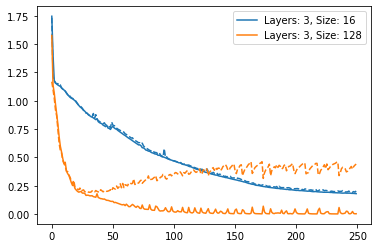

In [12]:
legend_elements = []
for idx, model_config in enumerate(model_configs):
    model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_10_trained_on_2048.pt")
    plt.plot(model['losses'], f'C{idx}')
    plt.plot(model['val_losses'], f'C{idx}--')

    legend_elements.append(Line2D([0], [0], color=f'C{idx}', label=f"Layers: {model_config[1]}, Size: {model_config[0]}"))

plt.legend(handles=legend_elements)

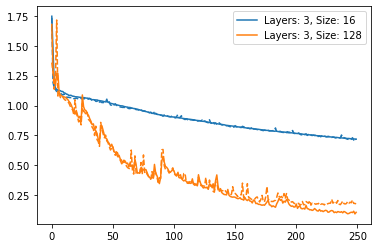

In [14]:
legend_elements = []
for idx, model_config in enumerate(model_configs):
    model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_20_trained_on_2048.pt")
    plt.plot(model['losses'], f'C{idx}')
    plt.plot(model['val_losses'], f'C{idx}--')

    legend_elements.append(Line2D([0], [0], color=f'C{idx}', label=f"Layers: {model_config[1]}, Size: {model_config[0]}"))

plt.legend(handles=legend_elements)

# Evaluate performance

In [42]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

### Just weight decay

In [46]:
for model_config in model_configs:
    print(model_config)
    for seq_length in seq_lengths:
        # Create the encoder and decoder models
        encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        
        encoder.cpu()
        decoder.cpu()
        
        model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048.pt")
        encoder.load_state_dict(model['encoder'])
        decoder.load_state_dict(model['decoder'])

        encoder.eval()
        decoder.eval()
        
        bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length, gpu=False)
        qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length, gpu=False)
        
        bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length)
        qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length)
        
        results = {'snr_range': snr_range,
                'bpsk_accs': bpsk_accs,
                'qpsk_accs': qpsk_accs,
                'bpsk_class_accuracy': bpsk_class_accuracy,
                'qpsk_class_accuracy': qpsk_class_accuracy}
        
        torch.save(results, f"results/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048.pt")

(16, 3)
(128, 3)


### Teacher forcing

In [45]:
tf_ratios = [0.25, 0.5]
for model_config in model_configs:
    print(model_config)
    for tf_ratio in tf_ratios:
        print(tf_ratio)
        for seq_length in seq_lengths:
            # Create the encoder and decoder models
            encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            
            encoder.cpu()
            decoder.cpu()
            
            model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048_tf_ratio_{tf_ratio}.pt")
            encoder.load_state_dict(model['encoder'])
            decoder.load_state_dict(model['decoder'])

            encoder.eval()
            decoder.eval()
            
            bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length, gpu=False)
            qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length, gpu=False)
            
            bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length)
            qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length)
            
            results = {'snr_range': snr_range,
                    'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accuracy': bpsk_class_accuracy,
                    'qpsk_class_accuracy': qpsk_class_accuracy}
            
            torch.save(results, f"results/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048_tf_ratio_{tf_ratio}.pt")

(16, 3)
0.25
0.5
(128, 3)
0.25
0.5


### Dropout

In [ ]:
for model_config in model_configs:
    print(model_config)
    for dropout in dropouts:
        print(dropout)
        for seq_length in seq_lengths:
            # Create the encoder and decoder models
            encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            
            encoder.cpu()
            decoder.cpu()
            
            model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048_dropout_{dropout}.pt")
            encoder.load_state_dict(model['encoder'])
            decoder.load_state_dict(model['decoder'])

            encoder.eval()
            decoder.eval()
            
            bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length, gpu=False)
            qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length, gpu=False)
            
            bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length)
            qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length)
            
            results = {'snr_range': snr_range,
                    'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accuracy': bpsk_class_accuracy,
                    'qpsk_class_accuracy': qpsk_class_accuracy}
            
            torch.save(results, f"results/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048_dropout_{dropout}.pt")